# **Potato Disease Classification**

**👨‍💻Author: Muhammad Hassaan**

[![GitHub](https://img.shields.io/badge/GitHub-Profile-blue?style=for-the-badge&logo=github)](https://github.com/iammuhammadhassaaan) 
[![Kaggle](https://img.shields.io/badge/Kaggle-Profile-blue?style=for-the-badge&logo=kaggle)](https://www.kaggle.com/mhassaan1122) 
[![LinkedIn](https://img.shields.io/badge/LinkedIn-Profile-blue?style=for-the-badge&logo=linkedin)](https://www.linkedin.com/in/iammuhammadhassaan7/)  
[![Email](https://img.shields.io/badge/Email-Contact%20Me-red?style=for-the-badge&logo=email)](mailto:muhammadhassaan7896@gmail.com)

**Problem Statement:**

Potatoes play a crucial role in feeding the world, but they’re often threatened by diseases like early blight and late blight, which can lead to major crop losses. Identifying these diseases the traditional way can be time-consuming and inefficient. By using machine learning to automatically classify potato leaf diseases, we can detect problems early and manage them more effectively, helping to protect harvests and support food security.

**Objective:**

Develop a deep learning model that accurately classifies potato leaf images into three categories:

1. **Healthy**
2. **Early Blight**
3. **Late Blight**

This model will assist farmers and agricultural professionals in promptly identifying and addressing potato diseases.

**Dataset:**

The project will utilize the PlantVillage dataset, specifically focusing on potato leaf images. The dataset includes images categorized as:

- **Potato___Early_blight**
- **Potato___Late_blight**
- **Potato___healthy**

These images are standardized to 256x256 pixels and are available in color. The dataset is publicly accessible on Kaggle. 

**Metadata:**

- **Dataset Name:** PlantVillage Dataset
- **Total Images:** Approximately 54,303 (subset for potato leaves)
- **Number of Classes:** 3 (specific to potato leaves)
- **Image Format:** JPEG
- **Image Size:** 256x256 pixels
- **Source:** PlantVillage Dataset on Kaggle
- **License:** CC0 1.0 Universal (CC0 1.0) Public Domain Dedication

**References:**

- [PlantVillage Dataset on Kaggle](https://www.kaggle.com/datasets/arjuntejaswi/plant-village/data)

---

### Importing Libraries

In [1]:
# core libraries 
import os 
import pandas as pd 
import numpy as np

# image processing libraries
from PIL import Image
import cv2

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 
import plotly.express as px

# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# warnings 
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set all the constants 
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../data",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


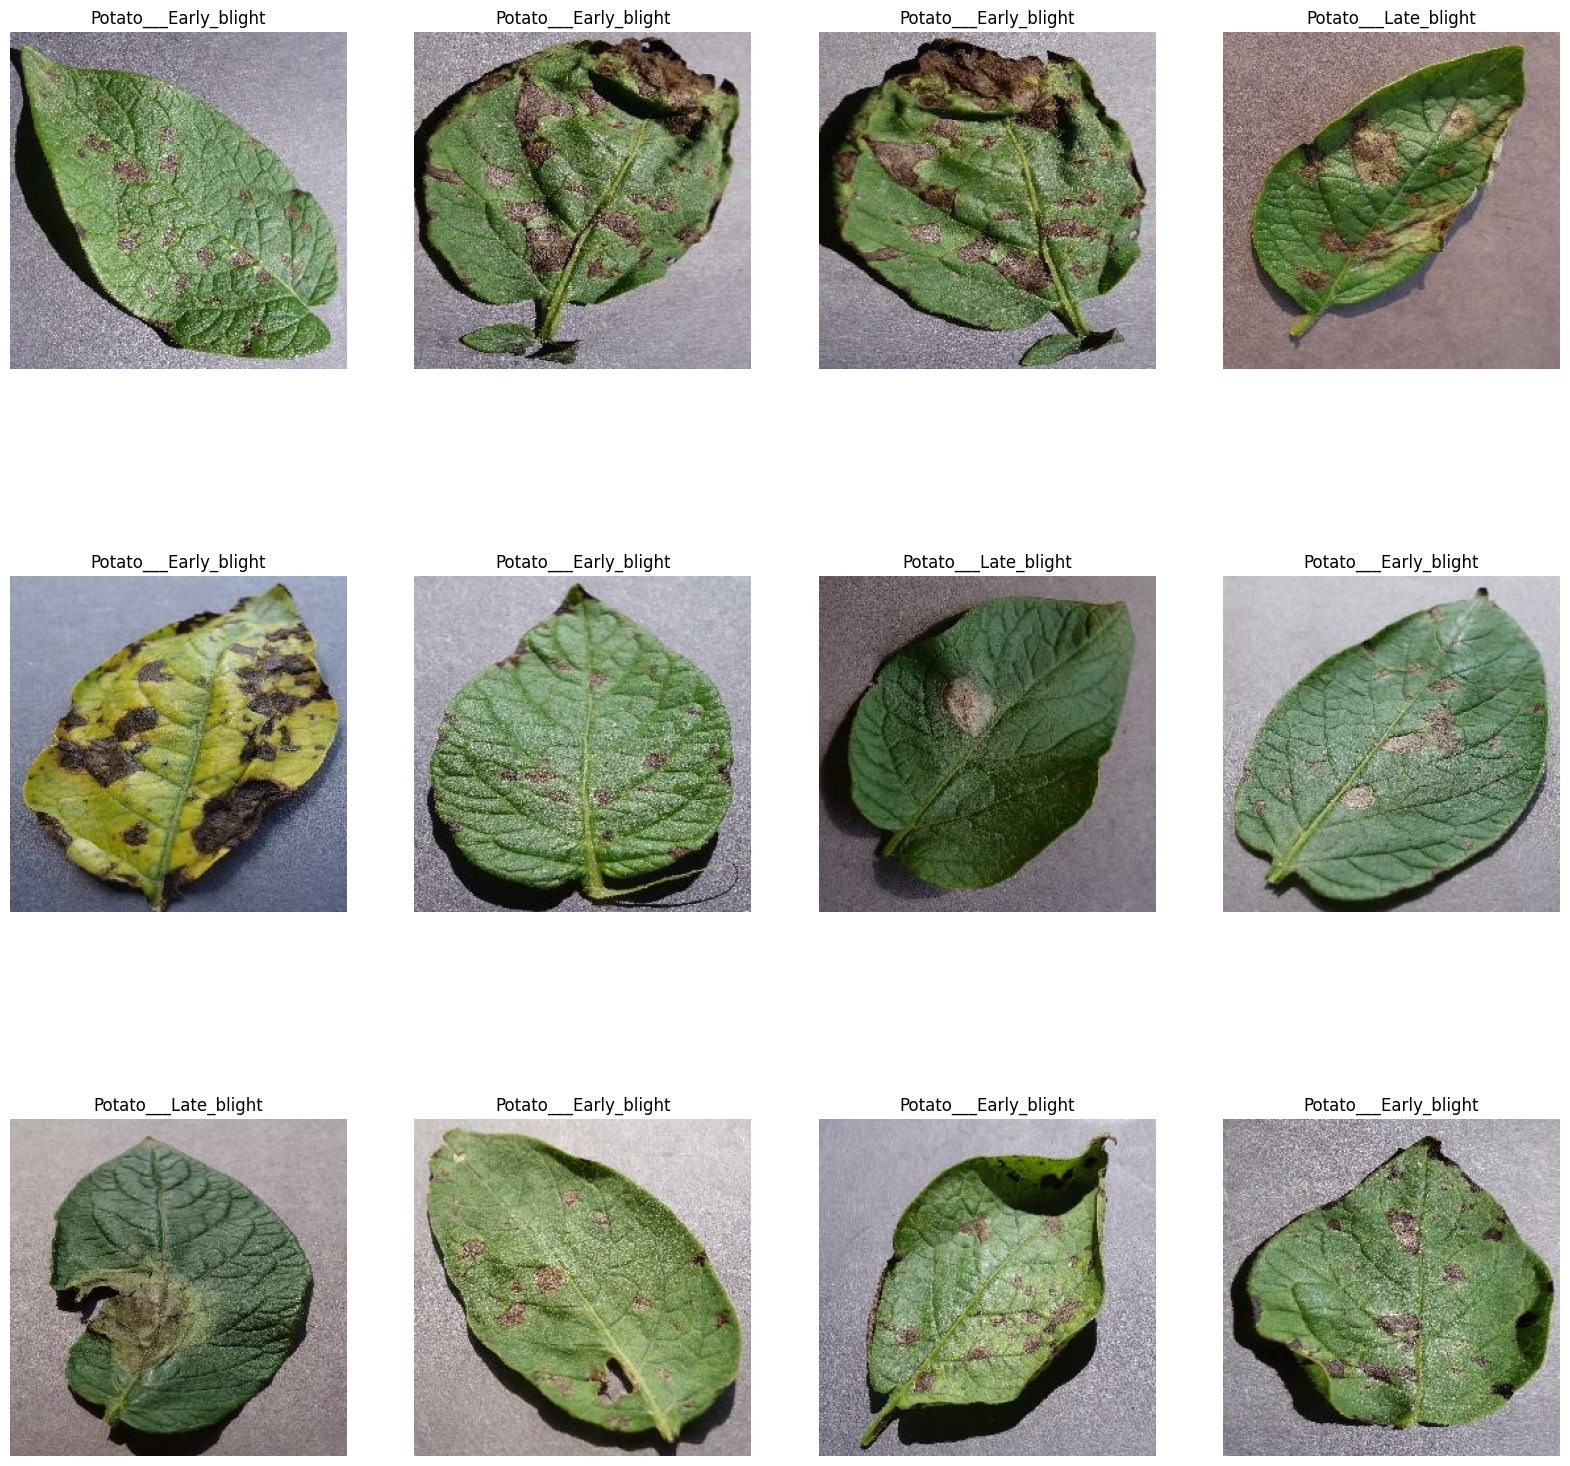

In [6]:
plt.figure(figsize=(20, 20))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [9]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
from tensorflow.keras import models, layers

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [15]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
 7/54 [==>...........................] - ETA: 8s - loss: 1.0076 - accuracy: 0.4464

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)
scores

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()